You are given a CSV dataset of an individual’s geolocation throughout a day from 10am to 5pm. The location coordinates are derived from mobile network base station cell towers with potentially up to 200m error.

### Questions:

1. The subscriber went to multiple locations during the day. Please identify possible POIs the subscriber visited and the corresponding dwell times.

2. How many journeys did the subscriber take throughout the day? Which are the origins/destinations of the journeys?

3. How would you derive the mode of transport for each journey based on time and geolocation information?

You are advised to overlay movement trajectory with free map services such as OpenStreetMap for clearer visualization.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

from math import sin, cos, sqrt, atan2, radians

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Data Analyst Assignment 1 Data.csv')

df.shape

(361, 6)

### Understanding and Preprocessing the Data

**starttime** – Unix timestamp of a session record start time

**endtime** – Unix timestamp of a session record end time

**samples** – Number of data samples for this session, higher value means more records received

**lat** – latitude of nearest base station

**lng** – longitude of nearest base station

**hour** – the hour of the timestamp

In [2]:
df.head()

,starttime,endtime,samples,lat,lng,hour
0,1651888844,1651888849,3,1.339736,103.883906,10
1,1651888897,1651888897,1,1.339736,103.883906,10
2,1651889682,1651889697,5,1.346736,103.877111,10
3,1651889832,1651889832,6,1.336738,103.885415,10
4,1651890425,1651891507,31,1.339736,103.883906,10


In [3]:
df.dtypes

starttime      int64
endtime        int64
samples        int64
lat          float64
lng          float64
hour           int64
dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   starttime  361 non-null    int64  
 1   endtime    361 non-null    int64  
 2   samples    361 non-null    int64  
 3   lat        361 non-null    float64
 4   lng        361 non-null    float64
 5   hour       361 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 17.0 KB


In [5]:
# convert to more readable datetime format first

df['starttime'] = pd.to_datetime(df['starttime'], unit = 's')
df['endtime'] = pd.to_datetime(df['endtime'], unit = 's')

df.head()

,starttime,endtime,samples,lat,lng,hour
0,2022-05-07 02:00:44,2022-05-07 02:00:49,3,1.339736,103.883906,10
1,2022-05-07 02:01:37,2022-05-07 02:01:37,1,1.339736,103.883906,10
2,2022-05-07 02:14:42,2022-05-07 02:14:57,5,1.346736,103.877111,10
3,2022-05-07 02:17:12,2022-05-07 02:17:12,6,1.336738,103.885415,10
4,2022-05-07 02:27:05,2022-05-07 02:45:07,31,1.339736,103.883906,10


In [6]:
# feature engineer duration_difference (in seconds) field from endtime and starttime

df['duration_diff_secs'] = (df.endtime - df.starttime).astype('timedelta64[s]')
df = df[['starttime', 'endtime', 'duration_diff_secs', 'samples', 'lat', 'lng', 'hour']]
df.head()

,starttime,endtime,duration_diff_secs,samples,lat,lng,hour
0,2022-05-07 02:00:44,2022-05-07 02:00:49,5.0,3,1.339736,103.883906,10
1,2022-05-07 02:01:37,2022-05-07 02:01:37,0.0,1,1.339736,103.883906,10
2,2022-05-07 02:14:42,2022-05-07 02:14:57,15.0,5,1.346736,103.877111,10
3,2022-05-07 02:17:12,2022-05-07 02:17:12,0.0,6,1.336738,103.885415,10
4,2022-05-07 02:27:05,2022-05-07 02:45:07,1082.0,31,1.339736,103.883906,10


In [7]:
df.dtypes

starttime             datetime64[ns]
endtime               datetime64[ns]
duration_diff_secs           float64
samples                        int64
lat                          float64
lng                          float64
hour                           int64
dtype: object

In [8]:
# feature engineer lagged lat and lng fields to calculate distance travelled
# but have to make sure that df is sorted by starttime first, if it isn't already

df = df.sort_values(by = 'starttime')

df['lat_lagged'] = df['lat'].shift(1)
df['lng_lagged'] = df['lng'].shift(1)

df.head()

,starttime,endtime,duration_diff_secs,samples,lat,lng,hour,lat_lagged,lng_lagged
0,2022-05-07 02:00:44,2022-05-07 02:00:49,5.0,3,1.339736,103.883906,10,NaN,NaN
1,2022-05-07 02:01:37,2022-05-07 02:01:37,0.0,1,1.339736,103.883906,10,1.339736,103.883906
2,2022-05-07 02:14:42,2022-05-07 02:14:57,15.0,5,1.346736,103.877111,10,1.339736,103.883906
3,2022-05-07 02:17:12,2022-05-07 02:17:12,0.0,6,1.336738,103.885415,10,1.346736,103.877111
4,2022-05-07 02:27:05,2022-05-07 02:45:07,1082.0,31,1.339736,103.883906,10,1.336738,103.885415


In [9]:
# calculate distance for one instance first (df index number 2)

# approximate radius of earth in km
R = 6373.0

lat1 = radians(1.346736)
lon1 = radians(103.877111)
lat2 = radians(1.339736)
lon2 = radians(103.883906)

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = round(R * c, 2)

distance

1.08

In [10]:
# create function for distance calculation

def dist_travelled_km(lat1, long1, lat2, long2):
    
    R = 6373.0

    lat1 = radians(lat1)
    long1 = radians(long1)
    lat2 = radians(lat2)
    long2 = radians(long2)
    
    dist_lon = long2 - long1
    dist_lat = lat2 - lat1
    
    a = sin(dist_lat / 2)**2 + cos(dist_lat) * cos(dist_lat) * sin(dist_lon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = round(R * c, 2)
    
    return distance

In [11]:
df['dist_travelled_from_prev_LatLong_km'] = df.apply(lambda x: dist_travelled_km(x.lat, x.lng, x.lat_lagged, x.lng_lagged), axis=1)
df.head()

,starttime,endtime,duration_diff_secs,samples,lat,lng,hour,lat_lagged,lng_lagged,dist_travelled_from_prev_LatLong_km
0,2022-05-07 02:00:44,2022-05-07 02:00:49,5.0,3,1.339736,103.883906,10,NaN,NaN,NaN
1,2022-05-07 02:01:37,2022-05-07 02:01:37,0.0,1,1.339736,103.883906,10,1.339736,103.883906,0.00
2,2022-05-07 02:14:42,2022-05-07 02:14:57,15.0,5,1.346736,103.877111,10,1.339736,103.883906,1.09
3,2022-05-07 02:17:12,2022-05-07 02:17:12,0.0,6,1.336738,103.885415,10,1.346736,103.877111,1.45
4,2022-05-07 02:27:05,2022-05-07 02:45:07,1082.0,31,1.339736,103.883906,10,1.336738,103.885415,0.37


In [12]:
df.drop(columns = ['lat_lagged', 'lng_lagged'], inplace = True)
df.head()

,starttime,endtime,duration_diff_secs,samples,lat,lng,hour,dist_travelled_from_prev_LatLong_km
0,2022-05-07 02:00:44,2022-05-07 02:00:49,5.0,3,1.339736,103.883906,10,NaN
1,2022-05-07 02:01:37,2022-05-07 02:01:37,0.0,1,1.339736,103.883906,10,0.00
2,2022-05-07 02:14:42,2022-05-07 02:14:57,15.0,5,1.346736,103.877111,10,1.09
3,2022-05-07 02:17:12,2022-05-07 02:17:12,0.0,6,1.336738,103.885415,10,1.45
4,2022-05-07 02:27:05,2022-05-07 02:45:07,1082.0,31,1.339736,103.883906,10,0.37


In [13]:
df.tail()

,starttime,endtime,duration_diff_secs,samples,lat,lng,hour,dist_travelled_from_prev_LatLong_km
356,2022-05-07 09:21:40,2022-05-07 09:21:40,0.0,6,1.342031,103.884621,17,0.60
357,2022-05-07 09:21:42,2022-05-07 09:21:42,0.0,12,1.336738,103.885415,17,0.60
358,2022-05-07 09:21:44,2022-05-07 09:21:44,0.0,6,1.342031,103.884621,17,0.60
359,2022-05-07 09:24:52,2022-05-07 09:52:19,1647.0,40,1.339736,103.883906,17,0.27
360,2022-05-07 09:51:33,2022-05-07 09:51:43,10.0,7,1.336738,103.885415,17,0.37


In [14]:
df.hour.unique()

array([10, 11, 12, 13, 14, 15, 16, 17])

In [15]:
df.hour.value_counts(normalize = True)

12    0.246537
11    0.229917
13    0.193906
17    0.127424
15    0.113573
16    0.055402
10    0.022161
14    0.011080
Name: hour, dtype: float64

<AxesSubplot:>

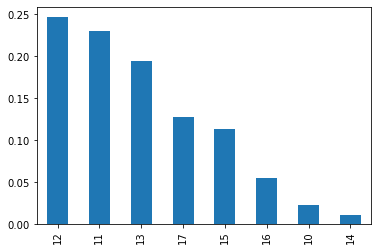

In [16]:
df.hour.value_counts(normalize = True).plot(kind = 'bar')

In [17]:
df.to_csv('starhub_df.csv', index = False)